In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import os
import copy
mpl.rcParams['figure.figsize'] = (6, 4)
mpl.rcParams['axes.grid'] = False

In [2]:
# reading the data into data frames using pandas
"""
data_csv is a list of 10 data frames holding a [2,] list for each symboL
the first one (for example data_csv[i][0] ) is the name of the symbol and
the second one (for example data_csv[i][1] ) is the data assosiated to it
"""
data_csv = []
i = 0
for filename in glob.glob('data/*.csv'):
    data_csv.append([filename[5:len(filename)-4],pd.read_csv(filename).drop("<TICKER>",1)])
    i+=1
# print(data_csv[0][0])
# data_csv[0][1].head()

In [25]:
data_frame = 5
features = data_csv[data_frame][1][['<OPEN>', '<CLOSE>', '<HIGH>', '<CLOSE>', '<VOL>']]
# features.index = data_csv[data_frame][1]['<DTYYYYMMDD>']
features.head()
# print(features.shape)
# features.plot(subplots=True)

,<OPEN>,<CLOSE>,<HIGH>,<CLOSE>,<VOL>
0,3213.0,3260.0,3500.0,3260.0,55879
1,3260.0,3260.0,3262.0,3260.0,99962
2,3270.0,3281.0,3351.0,3281.0,241949
3,3350.0,3281.0,3445.0,3281.0,415588
4,3340.0,3439.0,3439.0,3439.0,23538


In [31]:
def trun_to_windows(input,kernel):
    """
    Suppose that input is (T, F): T is the number of time steps and F is the number of features
    Then this function creates a list of data, label pairs in which data is (N, K, F) and label is (N, 1)
    N is the number of data, label pairs

    Inputs:
    - input: (T, F)
    - kernel: scalar and we call it K

    Outputs:
    - data: (N, K, F)
    - labels: (N, 1)
    """
    data = []
    labels = []
    for i in range(0,len(input)-kernel):
        data.append(input[i:i+kernel])
        labels.append(input[i+kernel][3])
    return np.array(data),np.array(labels).reshape((len(labels),1))

In [58]:
data,labels = trun_to_windows(features.values,20)
data_std = np.std(data, axis=0)
data_mean = np.mean(data, axis=0)
labels_std = np.std(labels, axis=0)
labels_mean = np.mean(labels, axis=0)
# data_back = copy.deepcopy(data)
# labels_back = copy.deepcopy(labels)
print(data.shape)
print(labels.shape)

(4172, 20, 5)
(4172, 1)


In [59]:
# normalize
data = (data - data_mean) / data_std
labels = (labels - labels_mean) / labels_std

In [60]:
model = keras.Sequential([
    keras.layers.LSTM(20, activation='relu', input_shape=data[0].shape, return_sequences=True),
    keras.layers.LSTM(10, activation='relu'),
    keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mae')
history = model.fit(data,labels,epochs=20,batch_size=32) 

Train on 4172 samples
Epoch 1/20
4172/4172 [==============================] - 10s 2ms/sample - loss: 0.1453
Epoch 2/20
4172/4172 [==============================] - 8s 2ms/sample - loss: 0.0553
Epoch 3/20
4172/4172 [==============================] - 8s 2ms/sample - loss: 0.0491
Epoch 4/20
4172/4172 [==============================] - 8s 2ms/sample - loss: 0.0432
Epoch 5/20
4172/4172 [==============================] - 8s 2ms/sample - loss: 0.0422
Epoch 6/20
4172/4172 [==============================] - 8s 2ms/sample - loss: 0.0351
Epoch 7/20
4172/4172 [==============================] - 8s 2ms/sample - loss: 0.0338
Epoch 8/20
4172/4172 [==============================] - 8s 2ms/sample - loss: 0.0337
Epoch 9/20
4172/4172 [==============================] - 8s 2ms/sample - loss: 0.0277
Epoch 10/20
4172/4172 [==============================] - 8s 2ms/sample - loss: 0.0273
Epoch 11/20
4172/4172 [==============================] - 8s 2ms/sample - loss: 0.0267
Epoch 12/20
4172/4172 [=================

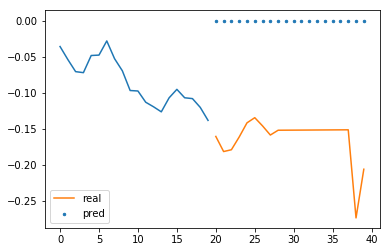

In [61]:
pred = []
i = 2111
gathered_data = []
for j in range(20):
    pred = model.predict(data[i+j].reshape(1, 20, 5))
    gathered_data.append(int(pred[0]))
plt.plot(range(20), list(data[i, :, 3]))
plt.scatter(range(20,40),gathered_data,s=6,label="pred")
plt.plot(range(20,40), list(data[20+i, :, 3]),label="real")
plt.legend()